# Example notebook

In [102]:
%matplotlib inline
from skimage import transform
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import torch
import time
import torch.nn.functional as F
from torch.utils.data import DataLoader
from floortrans.models import get_model
from floortrans.loaders import FloorplanSVG, DictToTensor, Compose, RotateNTurns
from floortrans.plotting import segmentation_plot, polygons_to_image, draw_junction_from_dict, discrete_cmap
discrete_cmap()
from floortrans.post_prosessing import split_prediction, get_polygons, split_validation
from mpl_toolkits.axes_grid1 import AxesGrid

rot = RotateNTurns()
room_classes = ["Background", "Outdoor", "Wall", "Kitchen", "Living Room" ,"Bed Room", "Bath", "Entry", "Railing", "Storage", "Garage", "Undefined"]
icon_classes = ["No Icon", "Window", "Door", "Closet", "Electrical Applience" ,"Toilet", "Sink", "Sauna Bench", "Fire Place", "Bathtub", "Chimney"]

data_folder = 'data/cubicasa5k/'
data_file = 'test.txt'
normal_set = FloorplanSVG(data_folder, data_file, format='txt', original_size=True)
data_loader = DataLoader(normal_set, batch_size=1, num_workers=0)
data_iter = iter(data_loader)
# Setup Model
model = get_model('hg_furukawa_original', 51)

n_classes = 44
split = [21, 12, 11]
model.conv4_ = torch.nn.Conv2d(256, n_classes, bias=True, kernel_size=1)
model.upsample = torch.nn.ConvTranspose2d(n_classes, n_classes, kernel_size=4, stride=4)
# checkpoint = torch.load('model_best_val_loss_var.pkl')

# model.load_state_dict(checkpoint['model_state'])
# model.eval()
# model.cuda()
# print("Model loaded.")

In [103]:
val = next(data_iter)
junctions = val['heatmaps']
folder = val['folder'][0]
image = val['image']#.cuda()
label = val['label']
np_img = np.moveaxis(image[0].cpu().data.numpy(), 0, -1) / 2 + 0.5
# plt.figure(figsize=(10,10))
# plt.title('Source Image', fontsize=20)
# plt.axis('off')
# plt.imshow(np_img)
# plt.show()

## The SVG floorplan
If the floorplan includes two floors the other floor might not be visible, but it will be parsed never the less.

In [104]:
# from IPython.display import Image
# from IPython.core.display import HTML 
# Image(url=data_folder+folder[1:]+"model.svg", width=800)

## Parsed labels

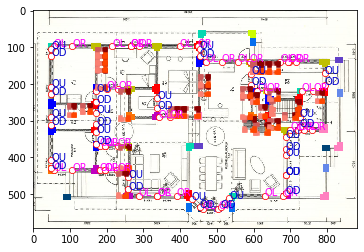

In [105]:
plt.imshow(np_img)
h, w, _ = np_img.shape
draw_junction_from_dict(junctions, w, h, size=0.3, fontsize=10)
plt.show()

In [106]:
import copy
import cv2
x = copy.copy(label_np[0])
x[label_np[0] != 1] = 0 

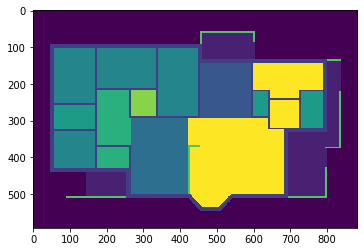

In [107]:
plt.imshow(label_np[0])

In [108]:
from scipy import ndimage

In [111]:
def demo_identify_polygon_with_correction(SegmentationMap,label):
    Final_junctions=[]
    Polygon_side=[]
    Areas=[]
    contours, _ = cv2.findContours(SegmentationMap,cv2.RETR_LIST,cv2.CHAIN_APPROX_SIMPLE)
    center = ndimage.measurements.center_of_mass(SegmentationMap,label,list(range(1,len(contours)+1)))
    for cnt in contours:
        if cv2.isContourConvex(cnt):
            side = len(cnt)
            Final_junctions.append(cnt.reshape(len(cnt),-1))
            Polygon_side.append(side)
            Areas.append(cv2.contourArea(cnt))
        else:
            #fix them into a polgon
            cnt = cv2.approxPolyDP(cnt, 0.009 * cv2.arcLength(cnt, True), True) 
            side = len(cnt)
            Final_junctions.append(cnt.reshape(len(cnt),-1))
            Polygon_side.append(side)
            Areas.append(cv2.contourArea(cnt))
            
    return Final_junctions,Polygon_side,center,Areas


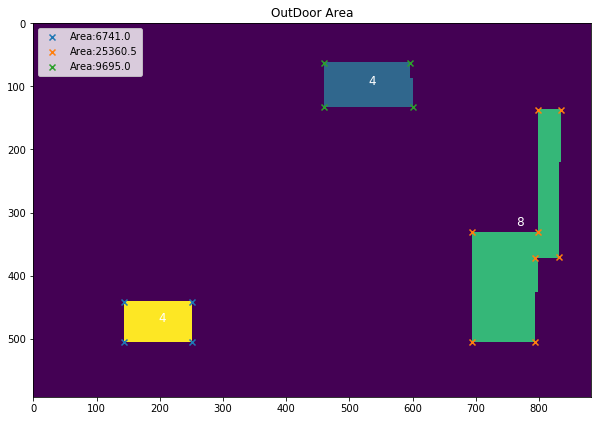

In [128]:
y = copy.copy(label_np[0])
y[label_np[0] != 1] = 0 
y = y.astype(np.uint8)
y_label = ndimage.label(y)[0]

plt.figure(figsize=(10,10))
plt.imshow(y_label)
plt.title("OutDoor Area")
Final_junctions,Polyon_side,center,Areas = demo_identify_polygon_with_correction(y,y_label)
for i in range(len(Final_junctions)):
    plt.scatter(Final_junctions[i][:,0],Final_junctions[i][:,1],marker="x",label ="Area:" + str(Areas[i]))
    y = max(Final_junctions[i][:,0]) - (max(Final_junctions[i][:,0])-min(Final_junctions[i][:,0]))/2
    x = max(Final_junctions[i][:,1]) - (max(Final_junctions[i][:,1])-min(Final_junctions[i][:,1]))/2
    plt.text(y, x, str(Polyon_side[i]), fontsize=12,color="white")
plt.legend(loc = "upper left")


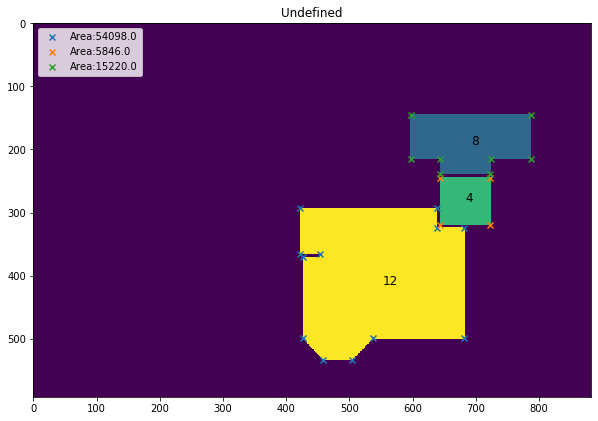

In [129]:
#Testing
y = copy.copy(label_np[0])
y[label_np[0] != 11] = 0 
y = y.astype(np.uint8)
y_label = ndimage.label(y)[0]

plt.figure(figsize=(10,10))
plt.imshow(y_label)
plt.title("Undefined")
Final_junctions,Polyon_side,center,Areas = demo_identify_polygon_with_correction(y,y_label)
for i in range(len(Final_junctions)):
    plt.scatter(Final_junctions[i][:,0],Final_junctions[i][:,1],marker="x",label ="Area:" + str(Areas[i]))
    y = max(Final_junctions[i][:,0]) - (max(Final_junctions[i][:,0])-min(Final_junctions[i][:,0]))/2
    x = max(Final_junctions[i][:,1]) - (max(Final_junctions[i][:,1])-min(Final_junctions[i][:,1]))/2
    plt.text(y, x, str(Polyon_side[i]), fontsize=12)
plt.legend(loc = "upper left")


Wall time: 1.47 s


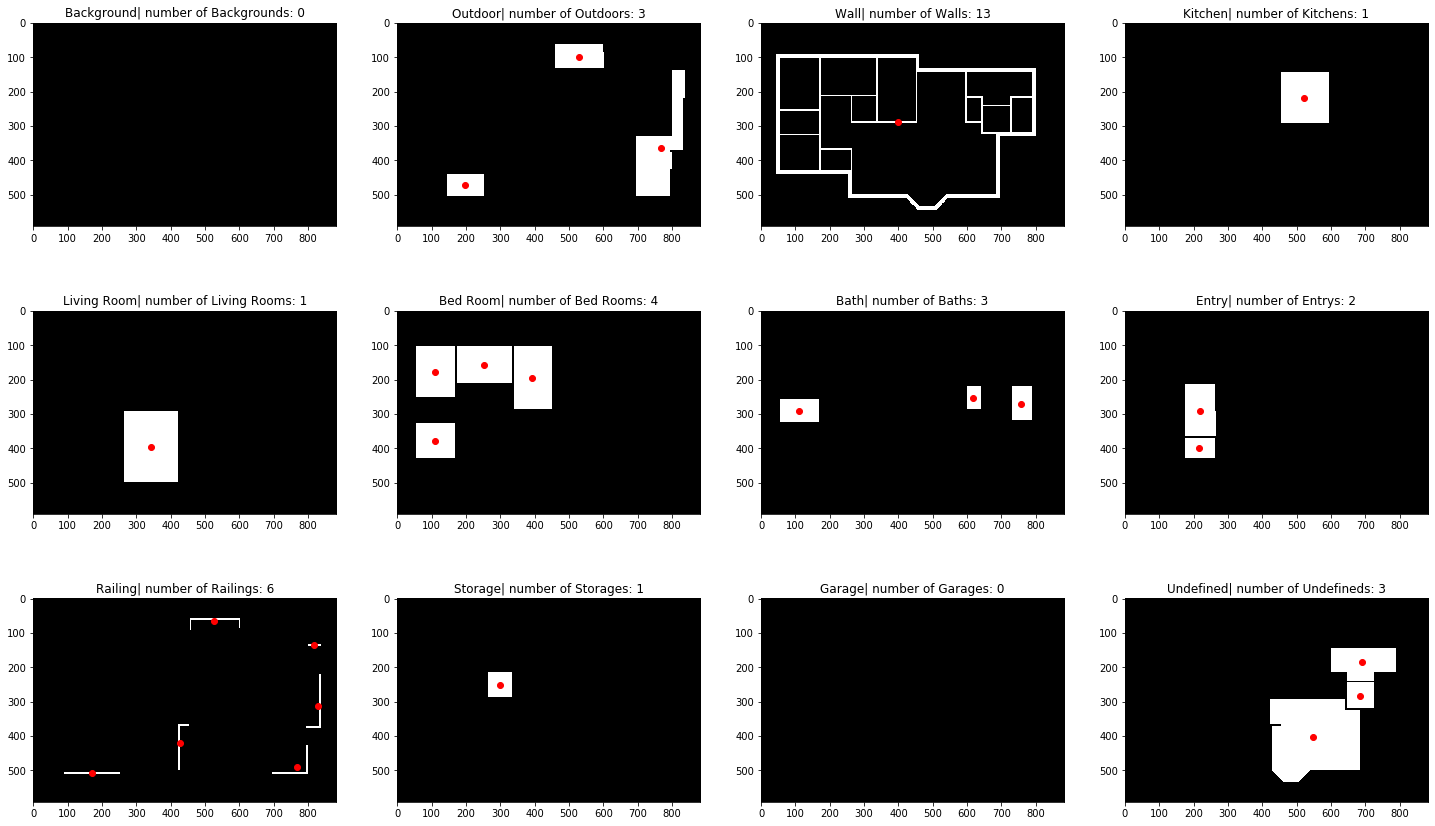

In [12]:
%%time
j = 0
k = 0 
fig,axes = plt.subplots(3,4,figsize=(25,15))

ROOM_POSITION_DIC={}
for i in range(12):
    if i % 4 ==0 and i !=0:
        j += 1
    if k == 4:
        k = 0 
    x = copy.copy(label_np[0])
    x[label_np[0] != i] = 0 
    x = x.astype(np.uint8)
    x_label = ndimage.label(x)[0]
    contours, _ = cv2.findContours(x,cv2.RETR_LIST,cv2.CHAIN_APPROX_SIMPLE)
    try:
        center = ndimage.measurements.center_of_mass(x,x_label,list(range(1,len(contours)+1)))
        ROOM_POSITION_DIC[room_classes[i]] = center
        for q in center:
            axes[j][k].scatter(q[1],q[0],c="red")
    except:
        pass
    
    axes[j][k].imshow(x,cmap="gray")
    axes[j][k].set_title(room_classes[i]+"| number of "+room_classes[i] + "s: "+ str(len(contours)))
    k+=1

    
    

In [112]:
#This is a dictionary that output rooms with its center of mass in pixel space
ROOM_POSITION_DIC

{'Background': [],
 'Outdoor': [(98.28874158883198, 529.6400522245656),
  (365.17260411440043, 766.8853294222085),
  (472.5, 197.5)],
 'Wall': [(286.7371086052113, 399.67828990584627),
  (nan, nan),
  (nan, nan),
  (nan, nan),
  (nan, nan),
  (nan, nan),
  (nan, nan),
  (nan, nan),
  (nan, nan),
  (nan, nan),
  (nan, nan),
  (nan, nan),
  (nan, nan)],
 'Kitchen': [(218.5, 522.5)],
 'Living Room': [(395.5, 343.0)],
 'Bed Room': [(178.0, 111.5), (157.0, 254.0), (195.5, 394.0), (379.0, 111.5)],
 'Bath': [(254.0, 617.5), (270.0, 758.0), (291.0, 111.5)],
 'Entry': [(291.55936675461743, 217.75197889182058), (400.0, 216.5)],
 'Railing': [(64.45544554455445, 526.2425742574258),
  (135.5, 817.0),
  (312.86528497409324, 829.3652849740932),
  (421.2, 426.7),
  (488.9673913043478, 767.4673913043479),
  (507.0, 170.0)],
 'Storage': [(251.5, 299.5)],
 'Garage': [],
 'Undefined': [(185.89109230669854, 690.9458045345908),
  (282.0, 683.5),
  (403.5658802377633, 547.725673295663)]}

Wall time: 618 ms


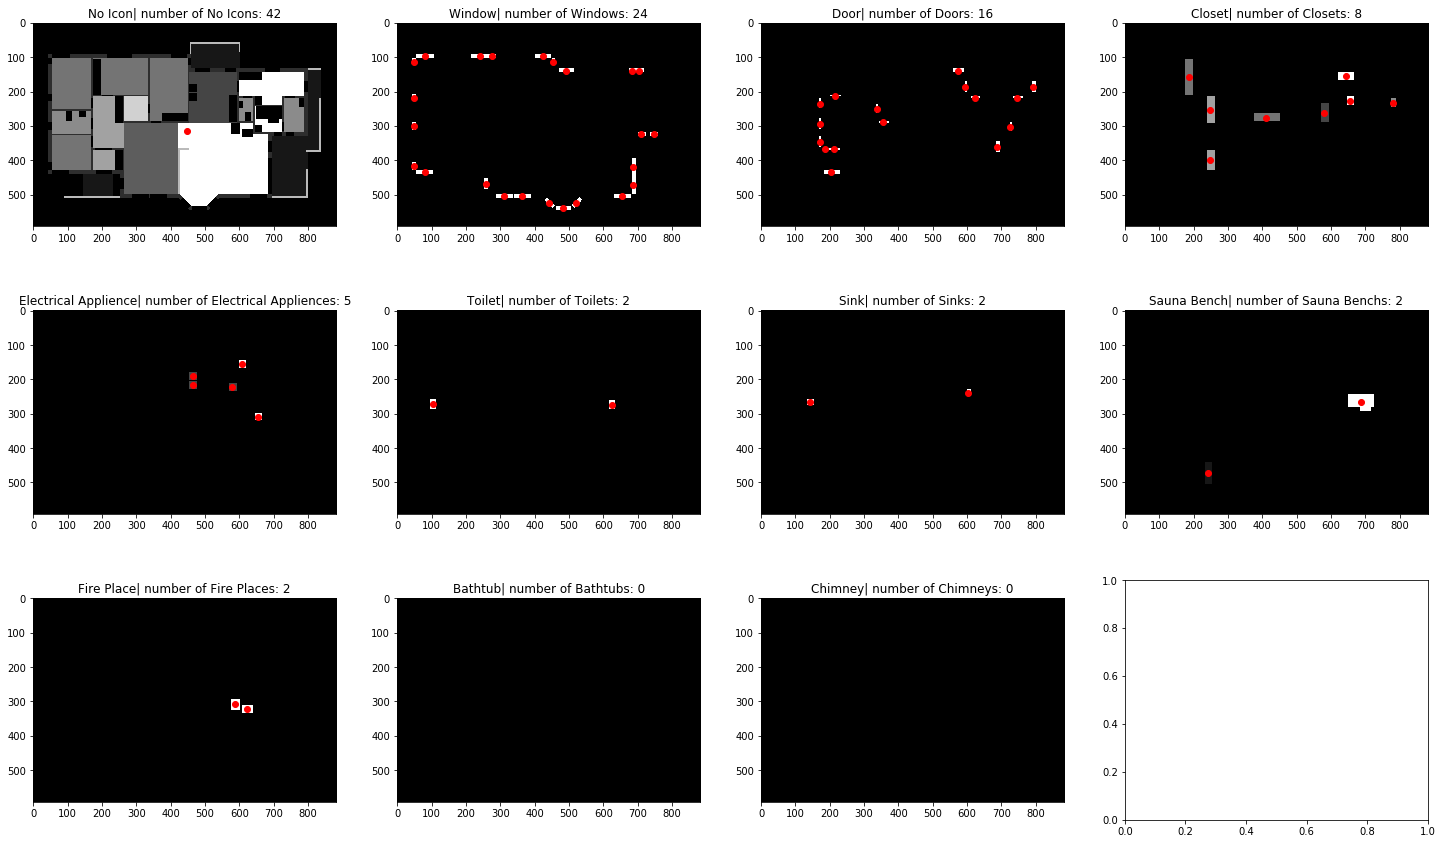

In [101]:
%%time
j = 0
k = 0 
ICON_POSITION_DIC={}
fig,axes = plt.subplots(3,4,figsize=(25,15))
for i in range(11):
    if i % 4 ==0 and i !=0:
        j += 1
    if k == 4:
        k = 0 
    x = copy.copy(label_np[0])
    x[label_np[1] != i] = 0 
    x = x.astype(np.uint8)
    x_label = ndimage.label(x)[0]
    contours, _ = cv2.findContours(x,cv2.RETR_LIST,cv2.CHAIN_APPROX_SIMPLE)
    try:
        center = ndimage.measurements.center_of_mass(x,x_label,list(range(1,len(contours)+1))) 
        ICON_POSITION_DIC[room_classes[i]] = center
        for q in center:
            axes[j][k].scatter(q[1],q[0],c="red")
    except:
        pass
    axes[j][k].imshow(x,cmap="gray")
    axes[j][k].set_title(icon_classes[i]+"| number of "+icon_classes[i] + "s: "+ str(len(contours)))

    k+=1



In [113]:
#This is a dictionary that output icons with its center of mass in pixel space
ICON_POSITION_DIC

{'Background': [(316.0751983261813, 448.3900542780877),
  (nan, nan),
  (nan, nan),
  (nan, nan),
  (nan, nan),
  (nan, nan),
  (nan, nan),
  (nan, nan),
  (nan, nan),
  (nan, nan),
  (nan, nan),
  (nan, nan),
  (nan, nan),
  (nan, nan),
  (nan, nan),
  (nan, nan),
  (nan, nan),
  (nan, nan),
  (nan, nan),
  (nan, nan),
  (nan, nan),
  (nan, nan),
  (nan, nan),
  (nan, nan),
  (nan, nan),
  (nan, nan),
  (nan, nan),
  (nan, nan),
  (nan, nan),
  (nan, nan),
  (nan, nan),
  (nan, nan),
  (nan, nan),
  (nan, nan),
  (nan, nan),
  (nan, nan),
  (nan, nan),
  (nan, nan),
  (nan, nan),
  (nan, nan),
  (nan, nan),
  (nan, nan)],
 'Outdoor': [(98.0, 81.0),
  (98.0, 240.0),
  (98.0, 277.0),
  (98.0, 423.5),
  (114.0, 454.0),
  (113.5, 50.0),
  (139.0, 491.0),
  (139.0, 683.5),
  (139.0, 705.0),
  (218.0, 50.0),
  (300.5, 50.0),
  (325.0, 711.0),
  (325.0, 746.5),
  (420.5, 688.0),
  (417.5, 50.0),
  (435.0, 80.5),
  (473.0, 688.0),
  (469.0, 258.0),
  (504.0, 311.5),
  (504.0, 364.0),
  (505.0